In [2]:
#1
import os, ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 # only used if we want to work on CSV
from src.data_utils import parse_list_col

pd.set_option("display.max_colwidth", 200)

In [4]:
#2
CLEAN_DIR = "../data/clean"
PARQ_PATH = os.path.join(CLEAN_DIR, "prs_clean.parquet")
CSV_PATH  = os.path.join(CLEAN_DIR, "prs_clean.csv")

if os.path.exists(PARQ_PATH):
    df_clean = pd.read_parquet(PARQ_PATH)
    print(f"Loaded Parquet rows={len(df_clean)}")
elif os.path.exists(CSV_PATH):
    # keep datetime on read
    df_clean = pd.read_csv(CSV_PATH, parse_dates=["created_at"])
    # rehydrate list columns
    if "reviewers_list" in df_clean.columns:
        df_clean["reviewers_list"] = parse_list_col(df_clean["reviewers_list"])
    if "labels_list" in df_clean.columns:
        df_clean["labels_list"] = parse_list_col(df_clean["labels_list"])
    print(f"Loaded CSV rows={len(df_clean)} (lists parsed)")
else:
    raise FileNotFoundError("No cleaned dataset found. Run data_load_and_clean first.")
display(df_clean.head(3))
print("Columns:", list(df_clean.columns))


Loaded Parquet rows=53


,id,number,title,author,body,created_at,state,labels,reviewers,labels_list,reviewers_list,body_clean,keyphrases
0,2801771679,55290,Fixed rows_processor in SQLInsertRowsOperator,dabla,"While testing the new providers in Airflow 3.0.6, I discovered an issue with the rows_processor in the SQLInsertRowsOperator. Added a unit test which tests this feature. --- ^ Add meaningful descr...",2025-09-05 07:43:33+00:00,closed,area:providers;provider:common-sql,eladkal,"[area:providers, provider:common-sql]",[eladkal],"While testing the new providers in Airflow 3.0.6, I discovered an issue with the rows_processor in the SQLInsertRowsOperator. Added a unit test which tests this feature. --- ^ Add meaningful descr...",the new providers | Airflow 3.0.6 | I | an issue | the rows_processor
1,2799915276,55269,Clear ti_summaries cache for a dagrun when a task instance is deleted to fetch updated summary.,tirkarthi,closes #55251,2025-09-04 15:35:43+00:00,closed,area:UI,pierrejeambrun,[area:ui],[pierrejeambrun],closes #55251,
2,2799094678,55261,Display the correct shared project while running shared distro tests,amoghrajesh,"<img width=""1179"" height=""549"" alt=""image"" src=""https://github.com/user-attachments/assets/13dd50dd-66be-4041-870f-1335d4531f23"" /> That isn't right ^ --- ^ Add meaningful description above Read t...",2025-09-04 11:43:18+00:00,closed,area:dev-tools;backport-to-v3-0-test,potiuk,"[area:dev-tools, backport-to-v3-0-test]",[potiuk],"That isn't right ^ --- ^ Add meaningful description above Read the Pull Request Guidelines for more information. In case of fundamental code changes, an Airflow Improvement Proposal (AIP) is neede...",That | meaningful description | more information | case | fundamental code changes


Columns: ['id', 'number', 'title', 'author', 'body', 'created_at', 'state', 'labels', 'reviewers', 'labels_list', 'reviewers_list', 'body_clean', 'keyphrases']


In [15]:
#3
# Safe no-op if already correct dtype from Parquet
df_clean["created_at"] = pd.to_datetime(df_clean["created_at"], utc=True, errors="coerce")
df_clean = df_clean.dropna(subset=["created_at"]).sort_values("created_at").reset_index(drop=True)

print("Date range:", df_clean["created_at"].min(), "→", df_clean["created_at"].max())
print("Rows after date cleaning:", len(df_clean))

Date range: 2025-08-29 01:17:04+00:00 → 2025-09-05 07:43:33+00:00
Rows after date cleaning: 53


state
closed    53
Name: count, dtype: int64

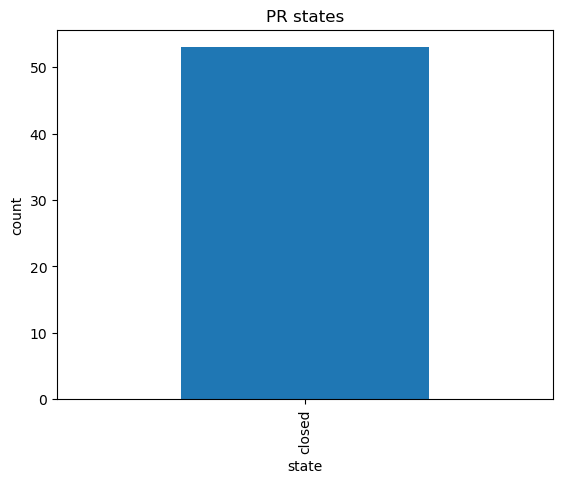

In [16]:
#4
# currently we have only 'closed' PRs in datasets.
state_counts = df_clean["state"].value_counts().sort_values(ascending=False)
display(state_counts)
state_counts.plot(kind="bar")
plt.title("PR states")
plt.xlabel("state"); plt.ylabel("count")
plt.show()


created_at
2025-08-31 00:00:00+00:00    24
2025-09-07 00:00:00+00:00    29
Freq: W-SUN, dtype: int64

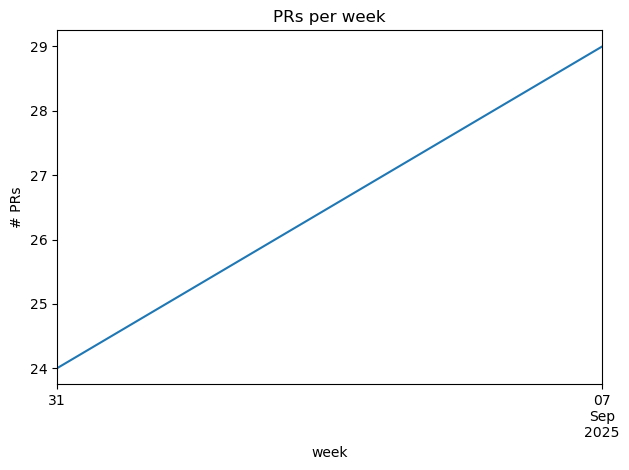

In [24]:
#5
# weekly PR volume (just for visual analysis)
weekly = df_clean.resample("W", on="created_at").size()
display(weekly.tail(10))

ax = weekly.plot()
ax.set_title("PRs per week"); ax.set_xlabel("week"); ax.set_ylabel("# PRs")
plt.tight_layout(); plt.show()

Top authors:


author
Lee-W                  5
jscheffl               5
tirkarthi              4
kaxil                  4
github-actions[bot]    3
dheerajturaga          3
guan404ming            3
amoghrajesh            3
potiuk                 2
olegkachur-e           2
Name: count, dtype: int64

Top reviewers:


reviewers_list
potiuk            18
lee-w              5
eladkal            5
pierrejeambrun     4
kaxil              3
bbovenzi           3
jedcunningham      3
jason810496        3
mobuchowski        3
jscheffl           2
Name: count, dtype: int64

Top labels:


labels_list
area:ui                  14
area:providers           12
area:dev-tools           10
area:api                  9
backport-to-v3-0-test     7
area:task-sdk             5
area:production-image     5
kind:documentation        5
provider:google           4
area:translations         3
Name: count, dtype: int64

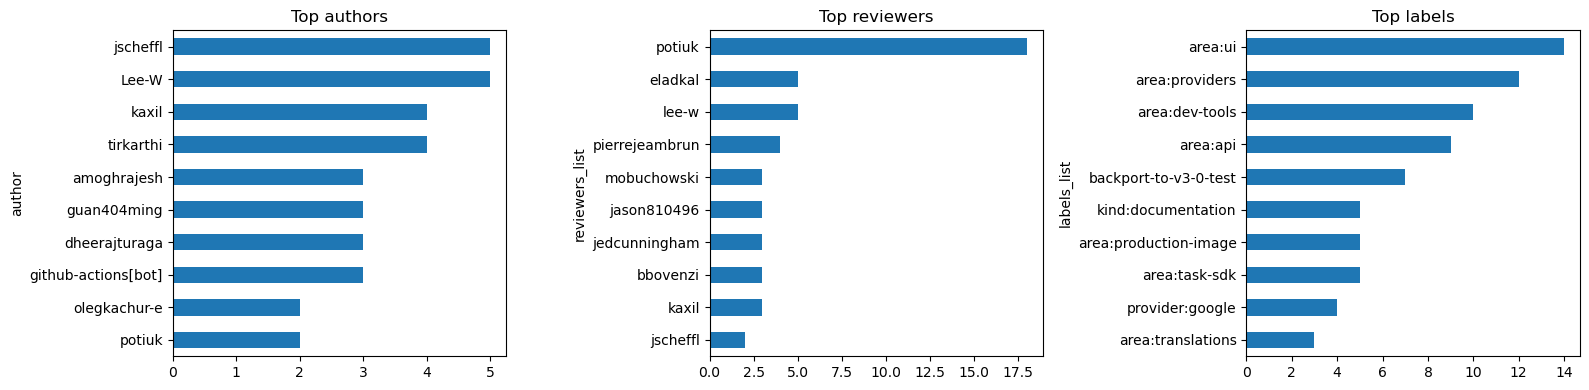

In [23]:
#6
top_n = 10
top_authors   = df_clean["author"].value_counts().head(top_n)
top_reviewers = df_clean["reviewers_list"].explode().value_counts().head(top_n)
top_labels    = df_clean["labels_list"].explode().value_counts().head(top_n)

print("Top authors:");   display(top_authors)
print("Top reviewers:"); display(top_reviewers)
print("Top labels:");    display(top_labels)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
top_authors.sort_values().plot(kind="barh", ax=axes[0]); axes[0].set_title("Top authors")
top_reviewers.sort_values().plot(kind="barh", ax=axes[1]); axes[1].set_title("Top reviewers")
top_labels.sort_values().plot(kind="barh", ax=axes[2]); axes[2].set_title("Top labels")
plt.tight_layout(); plt.show()


In [25]:
#7
pairs_ar = (
    df_clean[["author", "reviewers_list"]]
    .explode("reviewers_list")
    .rename(columns={"reviewers_list":"reviewer"})
    .dropna(subset=["reviewer"])
    .reset_index(drop=True)
)

author_reviewer_counts = (
    pairs_ar.value_counts()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(author_reviewer_counts.head(15))
print("Unique authors:", pairs_ar["author"].nunique(), " Unique reviewers:", pairs_ar["reviewer"].nunique())


,author,reviewer,count
0,Lee-W,potiuk,5
1,jscheffl,potiuk,3
2,guan404ming,lee-w,2
3,olegkachur-e,potiuk,2
4,tirkarthi,pierrejeambrun,2
5,kaxil,jedcunningham,2
6,dependabot[bot],potiuk,2
32,cnauroth,potiuk,1
26,VladaZakharova,gopidesupavan,1
27,amoghrajesh,eladkal,1


Unique authors: 28  Unique reviewers: 14


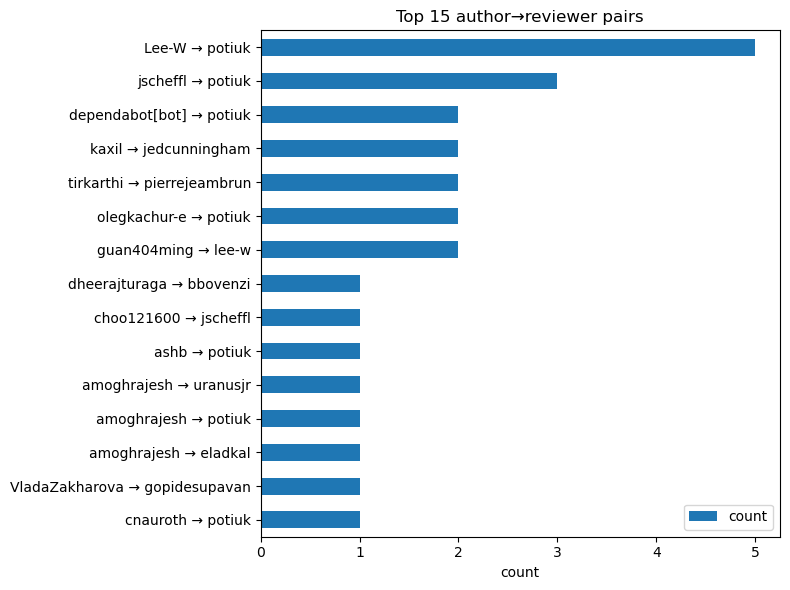

In [26]:
#8
# top author - reviewer paris
k = 15
plot_df = author_reviewer_counts.head(k).copy()
plot_df["pair"] = plot_df["author"] + " → " + plot_df["reviewer"]

ax = plot_df.sort_values("count").plot(x="pair", y="count", kind="barh", figsize=(8,6))
ax.set_title(f"Top {k} author→reviewer pairs")
ax.set_xlabel("count"); ax.set_ylabel("")
plt.tight_layout(); plt.show()


In [ ]:
#9
# author-label paris
pairs_al = (
    df_clean[["author", "labels_list"]]
    .explode("labels_list")
    .rename(columns={"labels_list":"label"})
    .dropna(subset=["label"])
    .reset_index(drop=True)
)

author_label_counts = (
    pairs_al.value_counts()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(author_label_counts.head(15))
print("Unique labels:", pairs_al["label"].nunique())


In [27]:
#10
# Label reviewer pairs
pairs_lr = (
    df_clean[["labels_list", "reviewers_list"]]
    .explode("labels_list")
    .explode("reviewers_list")
    .rename(columns={"labels_list":"label", "reviewers_list":"reviewer"})
    .dropna(subset=["label","reviewer"])
    .reset_index(drop=True)
)

label_reviewer_counts = (
    pairs_lr.value_counts()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(label_reviewer_counts.head(15))
print("Unique labels:", pairs_lr["label"].nunique(), " Unique reviewers:", pairs_lr["reviewer"].nunique())


,label,reviewer,count
0,area:dev-tools,potiuk,5
1,area:providers,potiuk,4
2,area:ui,bbovenzi,3
3,area:ui,pierrejeambrun,3
4,area:task-sdk,potiuk,3
5,backport-to-v3-0-test,potiuk,3
13,area:dev-tools,eladkal,2
19,kind:documentation,potiuk,2
18,area:ui,jscheffl,2
17,python,potiuk,2


Unique labels: 28  Unique reviewers: 14


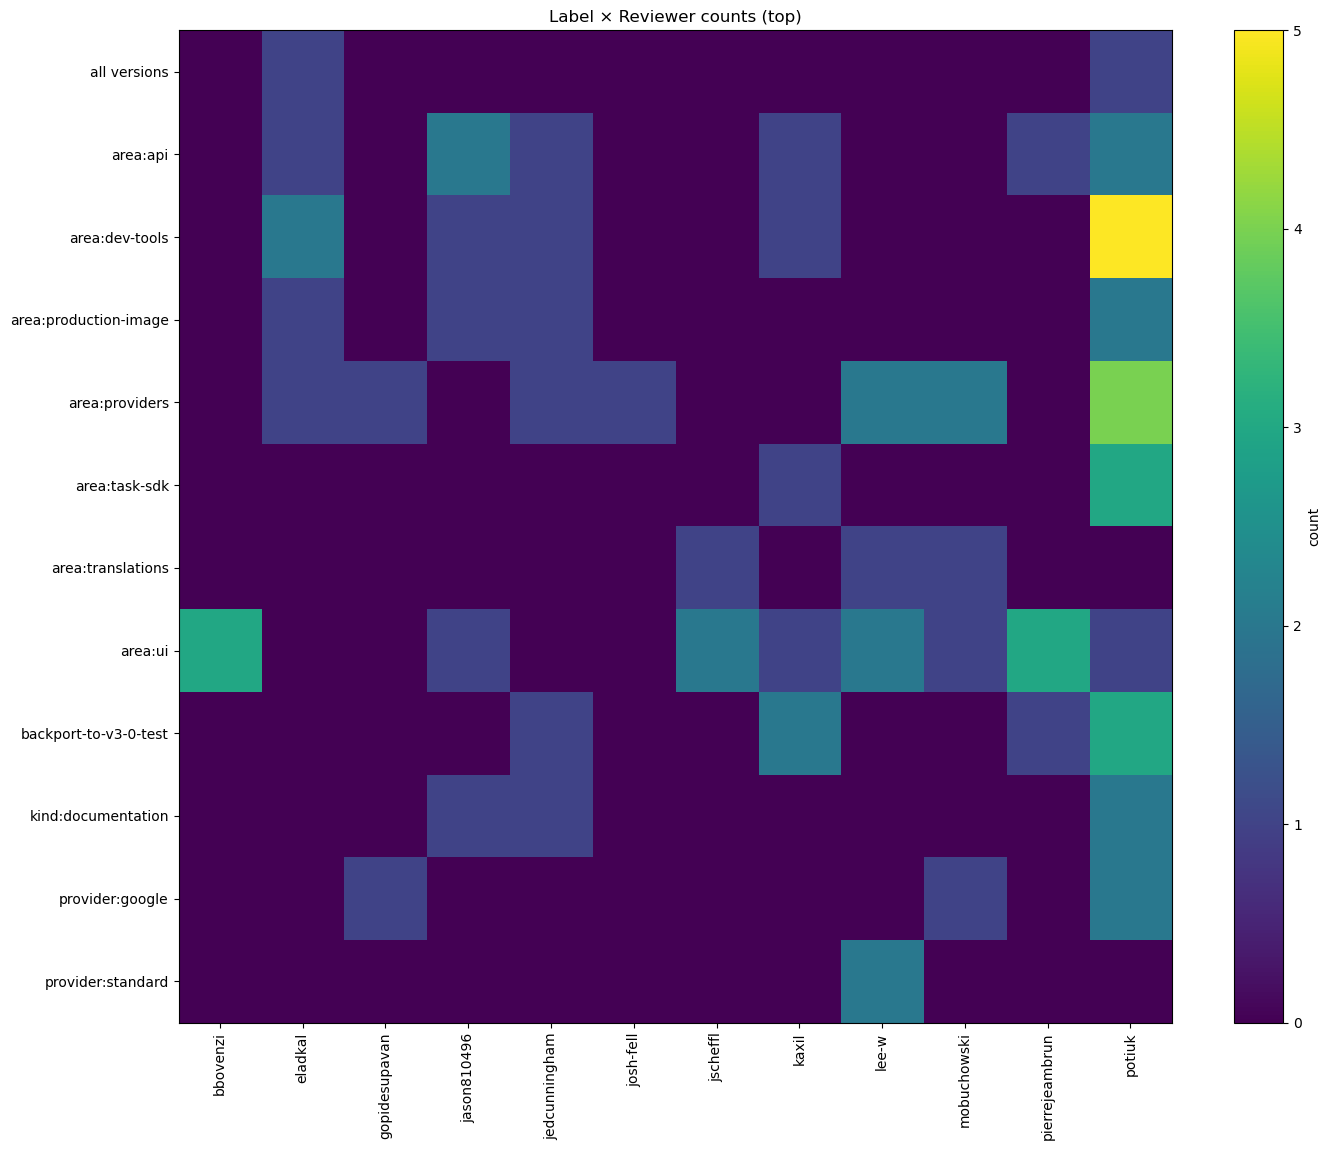

reviewer,bbovenzi,eladkal,gopidesupavan,jason810496,jedcunningham,josh-fell,jscheffl,kaxil,lee-w,mobuchowski,pierrejeambrun,potiuk
label,,,,,,,,,,,,
all versions,0,1,0,0,0,0,0,0,0,0,0,1
area:api,0,1,0,2,1,0,0,1,0,0,1,2
area:dev-tools,0,2,0,1,1,0,0,1,0,0,0,5
area:production-image,0,1,0,1,1,0,0,0,0,0,0,2
area:providers,0,1,1,0,1,1,0,0,2,2,0,4
area:task-sdk,0,0,0,0,0,0,0,1,0,0,0,3
area:translations,0,0,0,0,0,0,1,0,1,1,0,0
area:ui,3,0,0,1,0,0,2,1,2,1,3,1
backport-to-v3-0-test,0,0,0,0,1,0,0,2,0,0,1,3


In [29]:
#11
# label -reviewer heatmap
L = 12  # top labels
R = 12  # top reviewers

top_labels_idx = pairs_lr["label"].value_counts().head(L).index
top_revs_idx   = pairs_lr["reviewer"].value_counts().head(R).index

mat_df = (
    pairs_lr[pairs_lr["label"].isin(top_labels_idx) & pairs_lr["reviewer"].isin(top_revs_idx)]
    .value_counts()
    .reset_index(name="count")
    .pivot(index="label", columns="reviewer", values="count")
    .fillna(0).astype(int)
)

plt.figure(figsize=(1.2*R, 0.8*L + 2))
plt.imshow(mat_df.values, aspect="auto")
plt.colorbar(label="count")
plt.xticks(np.arange(mat_df.shape[1]), mat_df.columns, rotation=90)
plt.yticks(np.arange(mat_df.shape[0]), mat_df.index)
plt.title("Label × Reviewer counts (top)")
plt.tight_layout(); plt.show()

display(mat_df)


In [30]:
#12
# cold start check with time based split
cut = int(0.8 * len(df_clean))
tr = df_clean.iloc[:cut].copy()
te = df_clean.iloc[cut:].copy()

def set_of_reviewers(frame: pd.DataFrame):
    return set(r for lst in frame["reviewers_list"] for r in (lst or []))

tr_revs = set_of_reviewers(tr)
te_revs = set_of_reviewers(te)
unseen = te_revs - tr_revs

print(f"Train PRs: {len(tr)}  Test PRs: {len(te)}")
print(f"Unique reviewers — train: {len(tr_revs)}  test: {len(te_revs)}")
print(f"Unseen reviewers in test: {len(unseen)} ({(len(unseen)/max(1,len(te_revs))):.1%})")


Train PRs: 42  Test PRs: 11
Unique reviewers — train: 12  test: 8
Unseen reviewers in test: 2 (25.0%)
